# Prédiction de l'Attrition Client Bancaire : Pipeline de Machine Learning Distribué avec Apache Spark

* imports : 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, count, avg, max, min, when, desc
from pyspark.sql import functions as F
from pyspark.ml.feature import Imputer, StringIndexer
from pyspark.ml import Pipeline

import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(".."))

from fonctionss.approxquantile import outliers_detections_cols, outliers_detection_col, visualize_outliers
import pandas as pd
import matplotlib.pyplot as plt
from fonctionss.viz import viz, viz_all


from pyspark.sql import functions as F
from pyspark.sql import DataFrame

from pymongo import MongoClient




## 🟢 Configuration et Initialisation de Spark

### 1️⃣ Configuration de l’environnement Spark

#### - Installer et configurer PySpark

In [2]:
# Installation des dépendances ( exécuter dans le terminal)
"""
pip install pyspark==3.5.0
pip install pymongo
pip install findspark
"""

'\npip install pyspark==3.5.0\npip install pymongo\npip install findspark\n'

#### - Créer et tester une SparkSession

In [3]:

spark = SparkSession.builder \
    .appName("Banking_Churn_Prediction") \
    .master("local[*]") \
    .getOrCreate()




#### - Vérifier la version et les paramètres d’exécution

In [4]:
print("✅ SparkSession initialisée avec succès !")
print(f"Version de Spark : {spark.version}")

✅ SparkSession initialisée avec succès !
Version de Spark : 3.5.7


In [5]:
# Afficher quelques configurations importantes
print("\n⚙️  Paramètres Spark en cours d'exécution :")
for key, value in spark.sparkContext.getConf().getAll():
    print(f"{key} = {value}")



⚙️  Paramètres Spark en cours d'exécution :
spark.app.name = Banking_Churn_Prediction
spark.driver.extraJavaOptions = -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.app.startTime = 176

## 🟢 Chargement et Exploration des Données (EDA)

### 1️⃣ Charger les données brutes au format CSV dans un DataFrame Spark avec : spark.read.csv

In [6]:
df_clients = spark.read.csv(
    "../data/dataset.csv",
    header=True,
    inferSchema=True,
    sep=",",
    nullValue="NA"
)

print(f"✅ Données chargées avec succés !")
print(f"Nombre de lignes ; {df_clients.count()}")
print(f"Nombre de colonnes : {len(df_clients.columns)}")

✅ Données chargées avec succés !
Nombre de lignes ; 10000
Nombre de colonnes : 14


#### - Afficher le schéma des colonnes 

In [7]:
print(f"Schéma des colonnes : ")
df_clients.printSchema()

Schéma des colonnes : 
root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



#### - Afficher un aperçu des premières lignes


In [8]:
print("Aperçu des données :")
df_clients.show(5)

Aperçu des données :
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|          

### 2️⃣ Analyse exploratoire

#### - Statistiques descriptives globales

In [9]:

print(f"Statistiques descriptives globales : ")
print(f"Nombre total de lignes : {df_clients.count()}")
print(f"Nombre total de colonnes : {len(df_clients.columns)}")
print(f"Colonnes : {df_clients.columns}")



Statistiques descriptives globales : 
Nombre total de lignes : 10000
Nombre total de colonnes : 14
Colonnes : ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [10]:
print(f"Description des dataframe :")
df_clients.describe().show()

Description des dataframe :
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|             10000|            10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|


In [11]:
unique_val_counts = {
    c: df_clients.select(F.countDistinct(c).alias('distincts')).collect()[0]['distincts']
    for c in df_clients.columns
}

print(f"Valuers distinctes par colonne :")

for k, v in unique_val_counts.items():
    print(f" - {k}: {v}")

Valuers distinctes par colonne :
 - RowNumber: 10000
 - CustomerId: 10000
 - Surname: 2932
 - CreditScore: 460
 - Geography: 3
 - Gender: 2
 - Age: 70
 - Tenure: 11
 - Balance: 6382
 - NumOfProducts: 4
 - HasCrCard: 2
 - IsActiveMember: 2
 - EstimatedSalary: 9999
 - Exited: 2


#### - Identification des valeurs manquantes par colonne via la méthode df.select

In [12]:

missing_data = df_clients.select([
    spark_sum(col(c).isNull().cast("int")).alias(c) 
    for c in df_clients.columns
]).collect()[0]

total_rows = df_clients.count()
total_rows
print("Valeurs manquantes par colonne :")
print("-" * 40)

list_manquantes = []
for column in df_clients.columns:
    missing_count = missing_data[column]
    missing_percentage = (missing_count / total_rows) * 100
    list_manquantes.append({'columns': column, 'missing_count': missing_count, 'missing_percentage': missing_percentage})
    print(f"- {column}: {missing_count} valeurs manquantes ({missing_percentage:.2f}%)")
    
# pd.DataFrame(list_manquantes)


Valeurs manquantes par colonne :
----------------------------------------
- RowNumber: 0 valeurs manquantes (0.00%)
- CustomerId: 0 valeurs manquantes (0.00%)
- Surname: 0 valeurs manquantes (0.00%)
- CreditScore: 0 valeurs manquantes (0.00%)
- Geography: 0 valeurs manquantes (0.00%)
- Gender: 0 valeurs manquantes (0.00%)
- Age: 0 valeurs manquantes (0.00%)
- Tenure: 0 valeurs manquantes (0.00%)
- Balance: 0 valeurs manquantes (0.00%)
- NumOfProducts: 0 valeurs manquantes (0.00%)
- HasCrCard: 0 valeurs manquantes (0.00%)
- IsActiveMember: 0 valeurs manquantes (0.00%)
- EstimatedSalary: 0 valeurs manquantes (0.00%)
- Exited: 0 valeurs manquantes (0.00%)


In [13]:
n_rows = df_clients.count()
n_cols = len(df_clients.columns)

In [14]:
df_clients.dtypes

[('RowNumber', 'int'),
 ('CustomerId', 'int'),
 ('Surname', 'string'),
 ('CreditScore', 'int'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'int'),
 ('IsActiveMember', 'int'),
 ('EstimatedSalary', 'double'),
 ('Exited', 'int')]

In [15]:
numeric_cols = [col_name for col_name, dtype in df_clients.dtypes if dtype in ("int", "double")]
print("Colonnes numériques détectées:", numeric_cols)


Colonnes numériques détectées: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


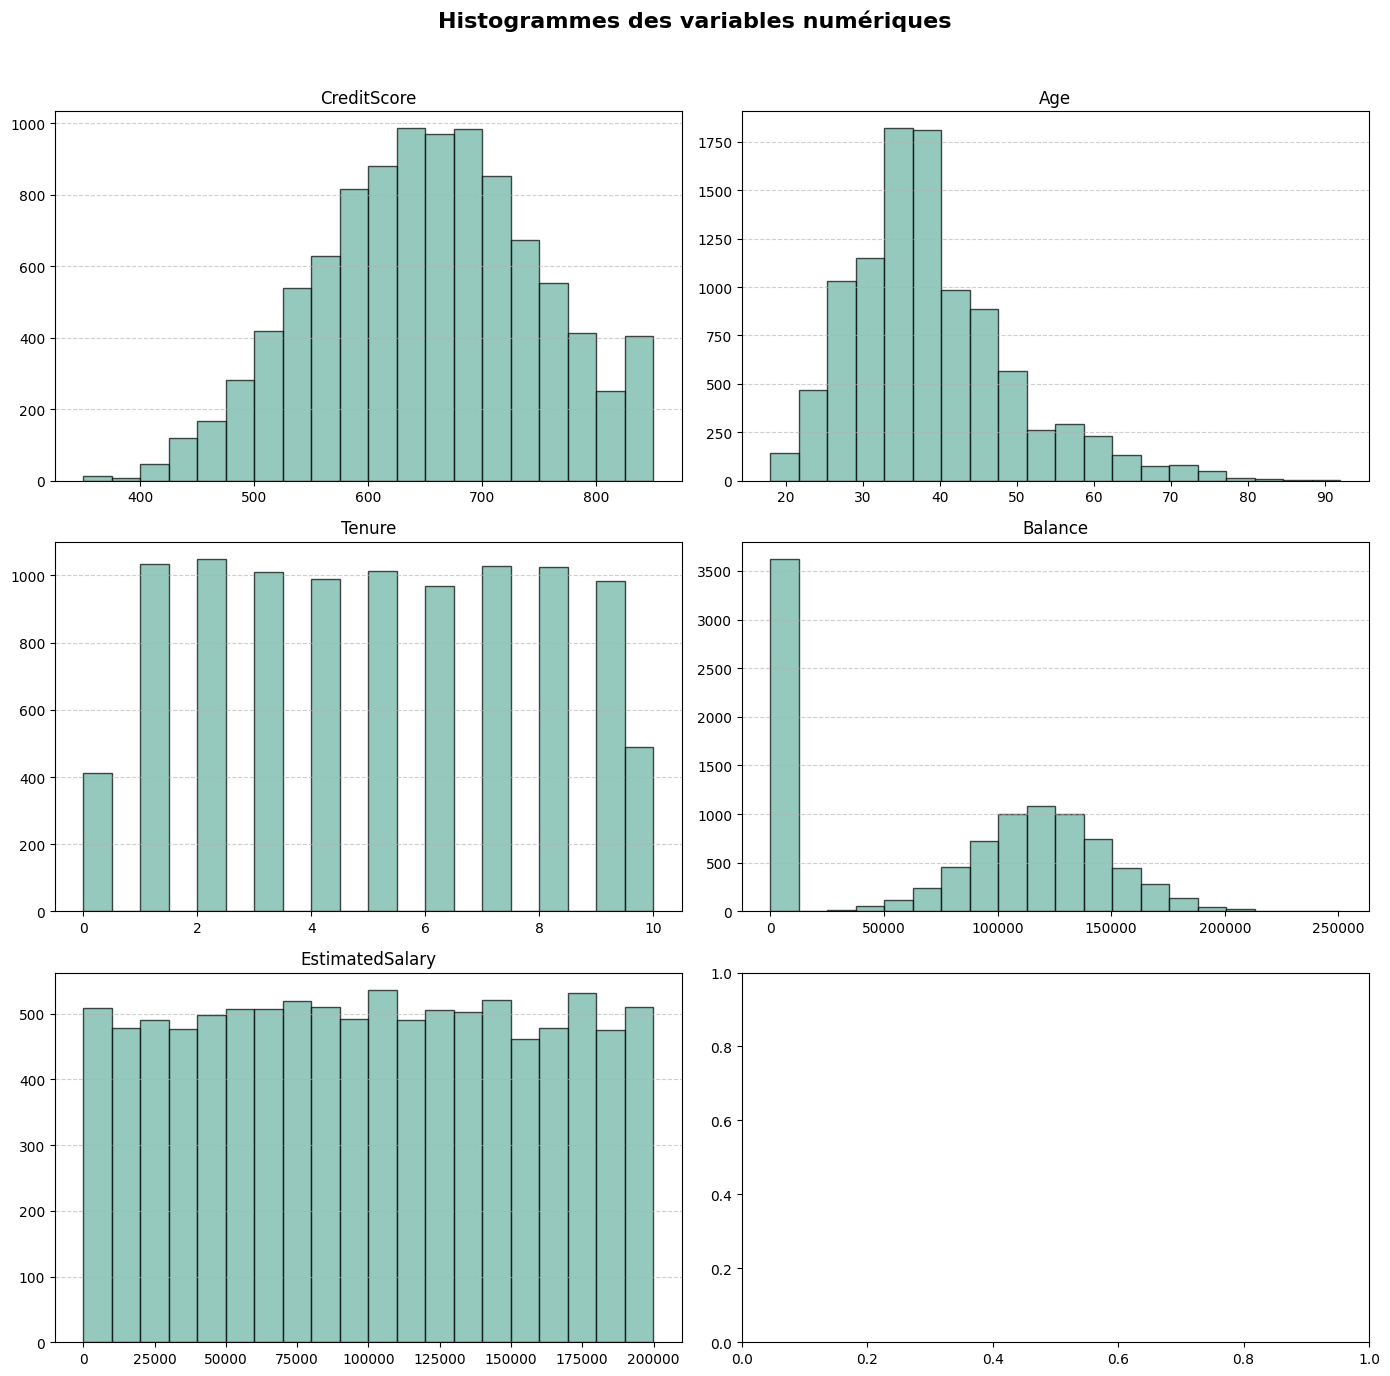

In [16]:

pdf = df_clients.toPandas()

num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
viz_all(pdf, num_cols)

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
CreditScore
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  584.0
Q3 (75%) :  714.0
IQR :  130.0
Total outlier :  17


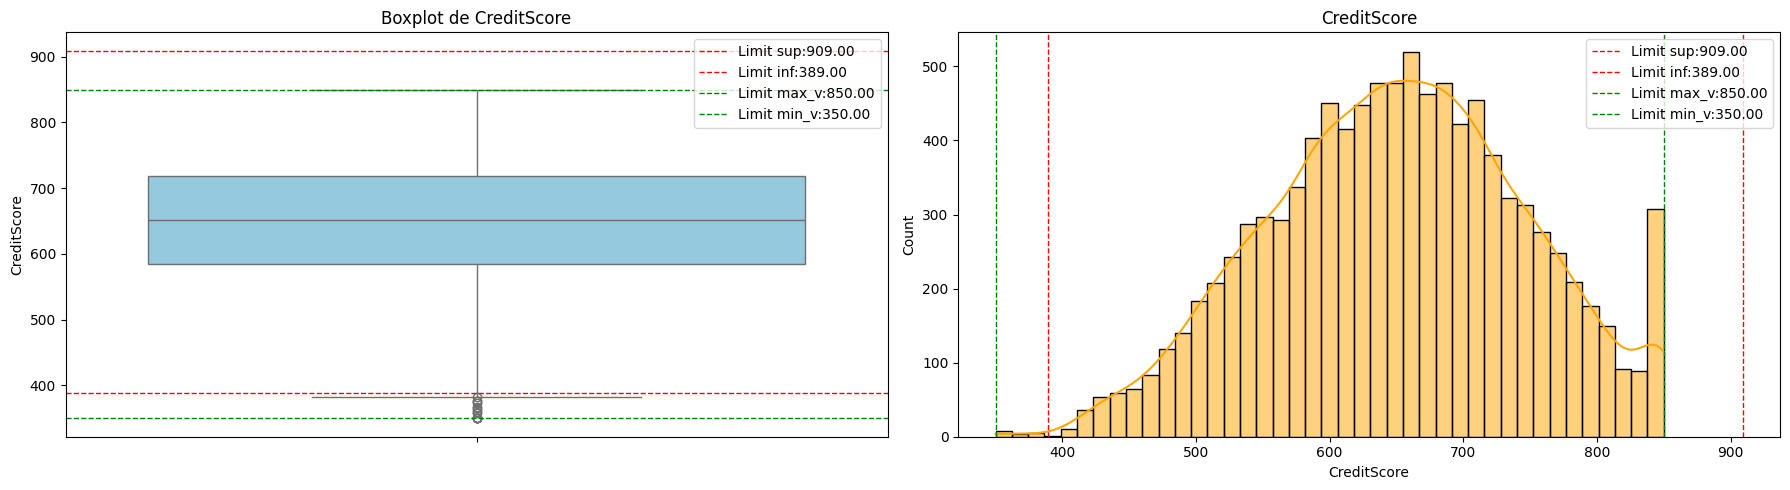

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Age
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  32.0
Q3 (75%) :  44.0
IQR :  12.0
Total outlier :  359


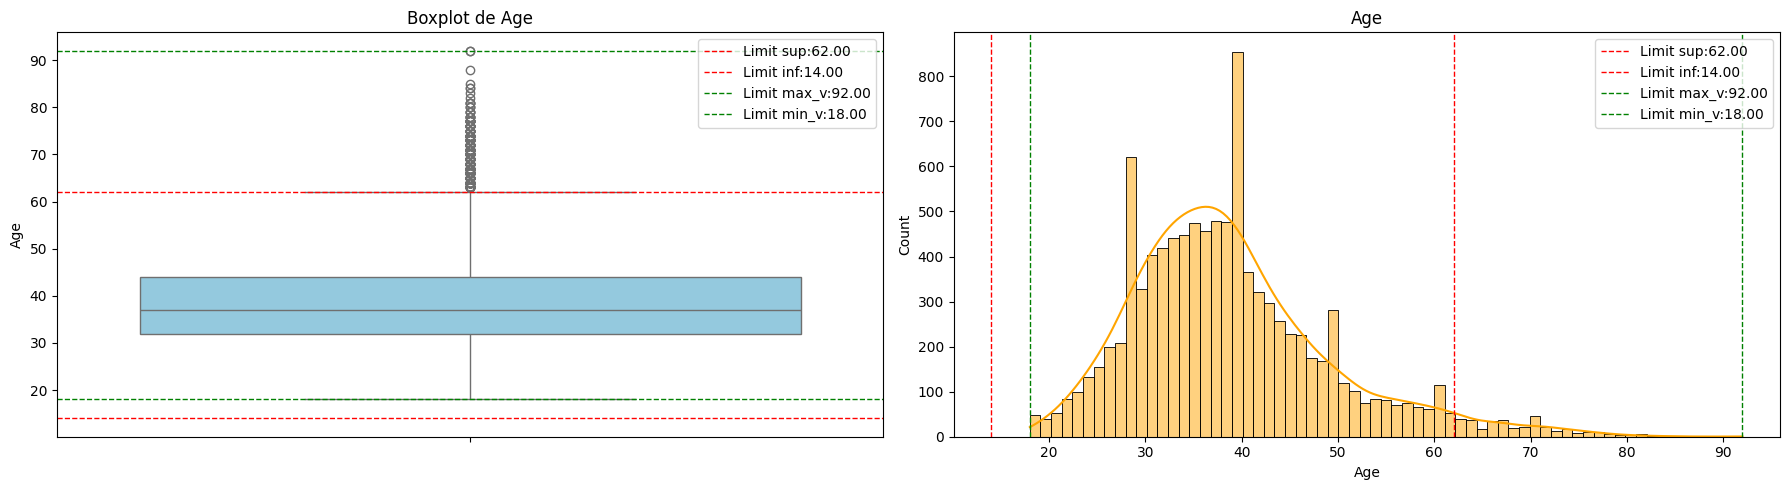

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Tenure
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  2.0
Q3 (75%) :  7.0
IQR :  5.0
Total outlier :  0


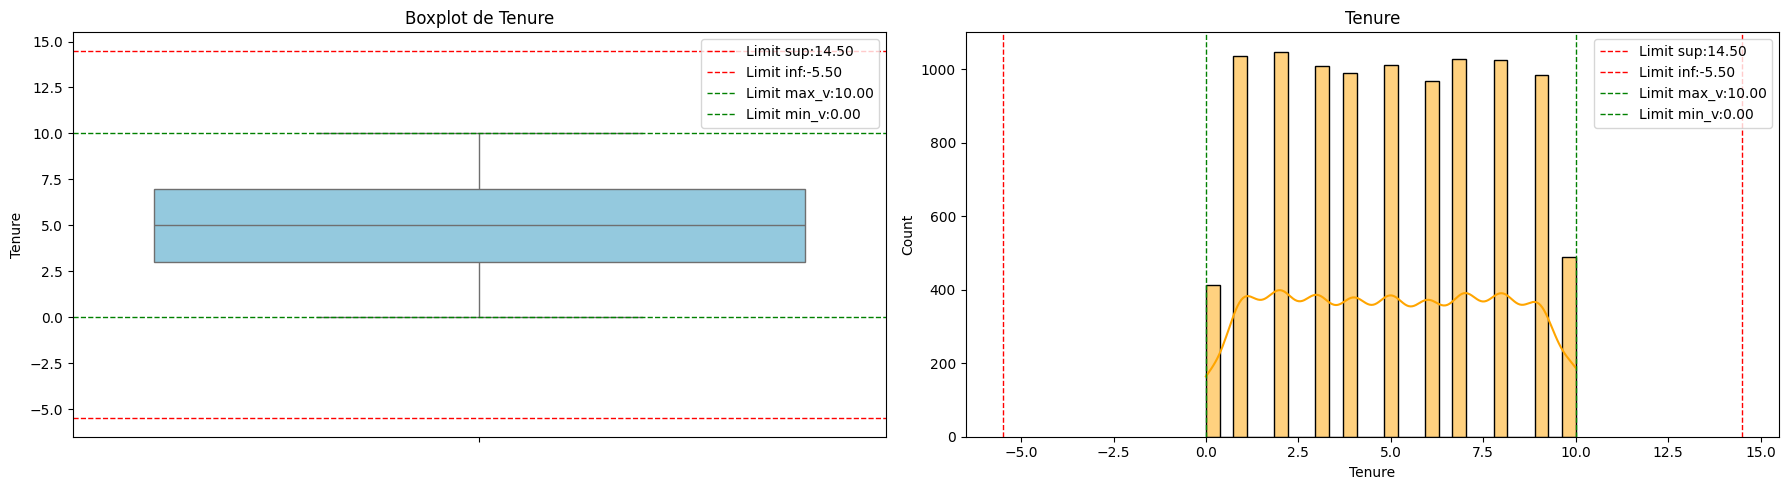

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Balance
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  0.0
Q3 (75%) :  126615.94
IQR :  126615.94
Total outlier :  0


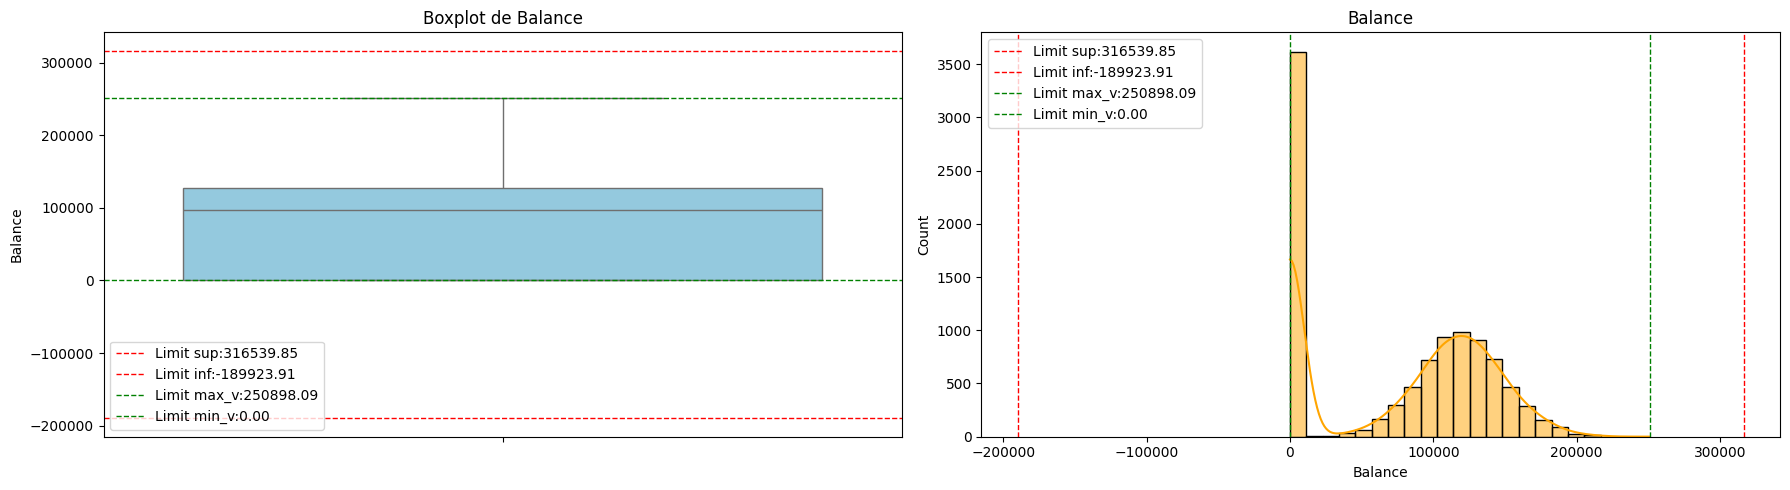

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
EstimatedSalary
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  50906.65
Q3 (75%) :  147342.03
IQR :  96435.38
Total outlier :  0


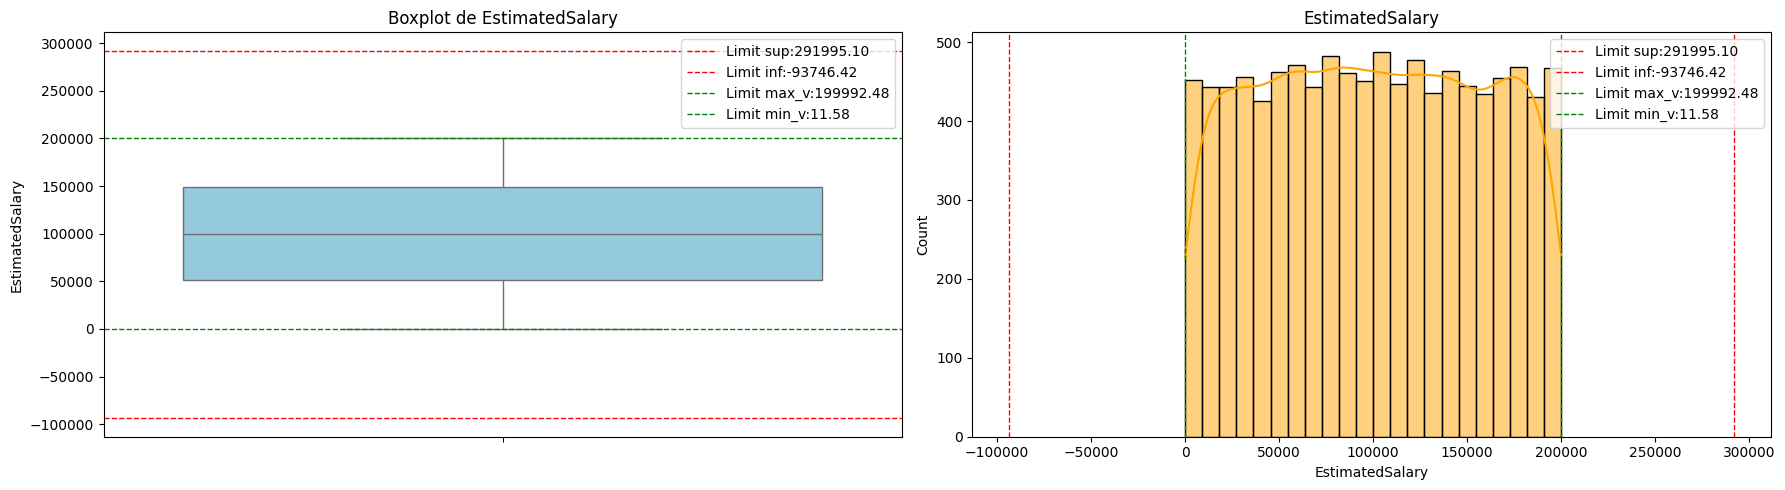

,col,Q1,Q3,IQR,lower,upper,outliers_total
0,CreditScore,584.00,714.00,130.00,389.00,909.00,17
1,Age,32.00,44.00,12.00,14.00,62.00,359
2,Tenure,2.00,7.00,5.00,-5.50,14.50,0
3,Balance,0.00,126615.94,126615.94,-189923.91,316539.85,0
4,EstimatedSalary,50906.65,147342.03,96435.38,-93746.42,291995.10,0


In [17]:

out_reports = outliers_detections_cols(df_clients, num_cols)
out_reports

#### - Analyse groupée (agrégations, moyennes, comptages)

* Répartition des clients par pays

In [18]:
df_clients.groupBy("Geography").count().show()

+---------+-----+
|Geography|count|
+---------+-----+
|  Germany| 2509|
|   France| 5014|
|    Spain| 2477|
+---------+-----+



* statistiques du score de crédit par pays :

In [19]:

df_clients.groupBy("Geography").agg(
    avg("CreditScore").alias("MoyenneScore"),
    max("CreditScore").alias("MaxScore"),
    min("CreditScore").alias("MinScore"),
    count("*").alias("NbClients")
).show()


+---------+-----------------+--------+--------+---------+
|Geography|     MoyenneScore|MaxScore|MinScore|NbClients|
+---------+-----------------+--------+--------+---------+
|  Germany|651.4535671582304|     850|     350|     2509|
|   France|649.6683286796969|     850|     350|     5014|
|    Spain|651.3338716188938|     850|     350|     2477|
+---------+-----------------+--------+--------+---------+



* statistiques du score de crédit par Gender :

In [20]:

df_clients.groupBy("Gender").agg(
    avg("CreditScore").alias("MoyenneScore"),
    max("CreditScore").alias("MaxScore"),
    min("CreditScore").alias("MinScore"),
    count("*").alias("NbClients")
).show()


+------+-----------------+--------+--------+---------+
|Gender|     MoyenneScore|MaxScore|MinScore|NbClients|
+------+-----------------+--------+--------+---------+
|Female| 650.831388950033|     850|     350|     4543|
|  Male|650.2768920652373|     850|     350|     5457|
+------+-----------------+--------+--------+---------+



* statistiques du score de crédit par pays et gender :

In [21]:

df_clients.groupBy(["Geography", "Gender"]).agg(
    avg("CreditScore").alias("MoyenneScore"),
    max("CreditScore").alias("MaxScore"),
    min("CreditScore").alias("MinScore"),
    count("*").alias("NbClients")
).orderBy(["Geography", "Gender"]).show()


+---------+------+-----------------+--------+--------+---------+
|Geography|Gender|     MoyenneScore|MaxScore|MinScore|NbClients|
+---------+------+-----------------+--------+--------+---------+
|   France|Female|649.1857585139319|     850|     350|     2261|
|   France|  Male|650.0646567381038|     850|     350|     2753|
|  Germany|Female|653.0938809723386|     850|     351|     1193|
|  Germany|  Male|649.9665653495441|     850|     350|     1316|
|    Spain|Female|651.7695133149679|     850|     358|     1089|
|    Spain|  Male|650.9920749279539|     850|     350|     1388|
+---------+------+-----------------+--------+--------+---------+



* Nombre de clients actifs vs inactifs

In [22]:
df_clients.groupBy("IsActiveMember").count().show()

+--------------+-----+
|IsActiveMember|count|
+--------------+-----+
|             1| 5151|
|             0| 4849|
+--------------+-----+



* Nombre de clients actifs vs inactifs par pays et gender

In [23]:

df_clients.groupBy(['Geography', 'Gender']).agg(
    spark_sum(when(col('IsActiveMember') == 1, 1).otherwise(0)).alias('ClientsActifs'),
    spark_sum(when(col('IsActiveMember') == 0, 1).otherwise(0)).alias('ClientsInactifs')
    
).orderBy(['Geography', 'Gender']).show()


+---------+------+-------------+---------------+
|Geography|Gender|ClientsActifs|ClientsInactifs|
+---------+------+-------------+---------------+
|   France|Female|         1162|           1099|
|   France|  Male|         1429|           1324|
|  Germany|Female|          559|            634|
|  Germany|  Male|          689|            627|
|    Spain|Female|          563|            526|
|    Spain|  Male|          749|            639|
+---------+------+-------------+---------------+



* Moyenne du solde bancaire (Balance) par ancienneté (Tenure)

In [24]:
df_clients.groupBy('Tenure').agg(
    avg("Balance").alias("MoyenneBalance")
).orderBy("Tenure").show()

+------+-----------------+
|Tenure|   MoyenneBalance|
+------+-----------------+
|     0|79878.91062953991|
|     1|78555.38422222226|
|     2| 76839.6264694657|
|     3|77668.05988107044|
|     4|74059.39406471176|
|     5|76444.28085968386|
|     6|74403.94263702171|
|     7|75551.63442607006|
|     8|77936.59825365855|
|     9|76562.54401422766|
|    10|73927.50400000003|
+------+-----------------+



* Corrélation entre produits et activité

In [25]:


df_clients.groupBy("NumOfProducts").agg(
    avg("CreditScore").alias("MoyScore"),
    avg("Balance").alias("MoyBalance"),
    count("*").alias("NbClients")
).orderBy(desc("MoyScore")).show()

+-------------+-----------------+-----------------+---------+
|NumOfProducts|         MoyScore|       MoyBalance|NbClients|
+-------------+-----------------+-----------------+---------+
|            4|653.5833333333334|93733.13500000001|       60|
|            2|652.1886710239652| 51879.1458126362|     4590|
|            1|649.1209677419355|98551.87061368999|     5084|
|            3|648.1052631578947|75458.32819548874|      266|
+-------------+-----------------+-----------------+---------+



* Taux de sortie (Exited) par pays

In [26]:
df_clients.groupBy("Geography").agg(
    spark_sum(when(col("Exited") == 1, 1).otherwise(0)).alias("ClientsSortis"),
    count("*").alias("TotalClients")
).withColumn("TauxSortie", F.round((col("ClientsSortis") / col("TotalClients")) * 100, 2)).show()


+---------+-------------+------------+----------+
|Geography|ClientsSortis|TotalClients|TauxSortie|
+---------+-------------+------------+----------+
|  Germany|          814|        2509|     32.44|
|   France|          810|        5014|     16.15|
|    Spain|          413|        2477|     16.67|
+---------+-------------+------------+----------+



* Score moyen par tranche d’âge

In [27]:

df_clients = df_clients.withColumn("TrancheAge",
    when(col("Age") < 25, "Jeunes")
    .when((col("Age") >= 25) & (col("Age") < 40), "Adultes")
    .when((col("Age") >= 40) & (col("Age") < 60), "Matures")
    .otherwise("Seniors")
)

df_clients.groupBy("TrancheAge").agg(avg("CreditScore").alias("ScoreMoyen")).show()


+----------+-----------------+
|TrancheAge|       ScoreMoyen|
+----------+-----------------+
|   Seniors|653.5380228136883|
|   Adultes|651.3065099457505|
|   Matures|648.3900200745627|
|    Jeunes|653.9737417943107|
+----------+-----------------+



* La répartition des client par rapport de pays et l'activation de member 

In [28]:


df_clients.groupBy("Geography", "IsActiveMember").agg(
    count("*").alias("NbClients"),
    avg("CreditScore").alias("MoyenneScore"),
    avg("Balance").alias("BalanceMoyenne")
).orderBy("Geography").show()


+---------+--------------+---------+-----------------+------------------+
|Geography|IsActiveMember|NbClients|     MoyenneScore|    BalanceMoyenne|
+---------+--------------+---------+-----------------+------------------+
|   France|             0|     2423| 646.894758563764| 63463.57623194396|
|   France|             1|     2591|652.2620609803165| 60810.58829795451|
|  Germany|             0|     1261|648.3243457573354|119587.11417129268|
|  Germany|             1|     1248|654.6153846153846|119874.60770032044|
|    Spain|             0|     1165|649.8377682403434| 59616.30663519313|
|    Spain|             1|     1312|652.6623475609756|63773.288704268256|
+---------+--------------+---------+-----------------+------------------+



* La répartition des client par rapport de pays et l'obtention de card'

In [29]:

df_clients.groupBy("Geography", "HasCrCard").agg(
    count("*").alias("NbClients"),
    avg("CreditScore").alias("MoyenneScore"),
    avg("Balance").alias("BalanceMoyenne")
).orderBy("Geography").show()


+---------+---------+---------+-----------------+------------------+
|Geography|HasCrCard|NbClients|     MoyenneScore|    BalanceMoyenne|
+---------+---------+---------+-----------------+------------------+
|   France|        0|     1471|647.2324949014276| 64554.58456832093|
|   France|        1|     3543|650.6796500141123| 61070.47292972058|
|  Germany|        0|      718|657.3175487465181|118211.54742339834|
|  Germany|        1|     1791|649.1027359017309|120338.90024008919|
|    Spain|        0|      756| 653.675925925926| 65662.74390211645|
|    Spain|        1|     1721|650.3050552004648|  60129.2955374781|
+---------+---------+---------+-----------------+------------------+



## 🟢  Prétraitement des Données

### 1️⃣ Nettoyage et imputation

* Suppression des colonnes non pertinentes

In [30]:
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname', 'TrancheAge']

df_clean = df_clients.drop(*cols_to_drop)
df_clean.printSchema()

print("Nombre de colonnes avant :", len(df_clients.columns))
print("Nombre de colonnes après :", len(df_clean.columns))


root
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)

Nombre de colonnes avant : 15
Nombre de colonnes après : 11


* Imputation des valeurs manquantes (Imputer avec stratégie mean, median ou mode)

In [31]:
df_clean.columns

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [32]:
from pyspark.sql.functions import col, sum

df_clean.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_clean.columns]).show()


+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



In [33]:
imputer = Imputer(
    inputCols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited"],
    outputCols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited"]
).setStrategy("median")

df_imputed = imputer.fit(df_clean).transform(df_clean)
df_imputed.show(5)

+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|
|        850|    Spain|Female| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|
+-----------+---------+------+---+------+---------+-------------+---------+-------------

### 2️⃣ Encodage et normalisation

* Encodage des variables catégorielles (StringIndexer, OneHotEncoder)

In [34]:
categ_cols = ["Geography", "Gender"]

indexers = [StringIndexer(inputCol=c, outputCol=c+"_Index", handleInvalid="keep") for c in categ_cols]

pipeline = Pipeline(stages=indexers)
df_encoded = pipeline.fit(df_imputed).transform(df_imputed)

df_encoded = df_encoded.withColumn("Geography_Index", col("Geography_Index").cast("int"))
df_encoded = df_encoded.withColumn("Gender_Index", col("Gender_Index").cast("int"))

df_encoded = df_encoded.drop(*categ_cols)


In [35]:
df_encoded.show(5)

+-----------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|CreditScore|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Geography_Index|Gender_Index|
+-----------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|        619| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|              0|           1|
|        608| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|              2|           1|
|        502| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|              0|           1|
|        699| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|              0|           1|
|        850| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|              2|      

***

* gestion des outliers :

visualisation des histogrames des colonnes qui contiennent des outliers ('Age', et 'CreditScore') : 

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
CreditScore
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  584.0
Q3 (75%) :  714.0
IQR :  130.0
Total outlier :  17


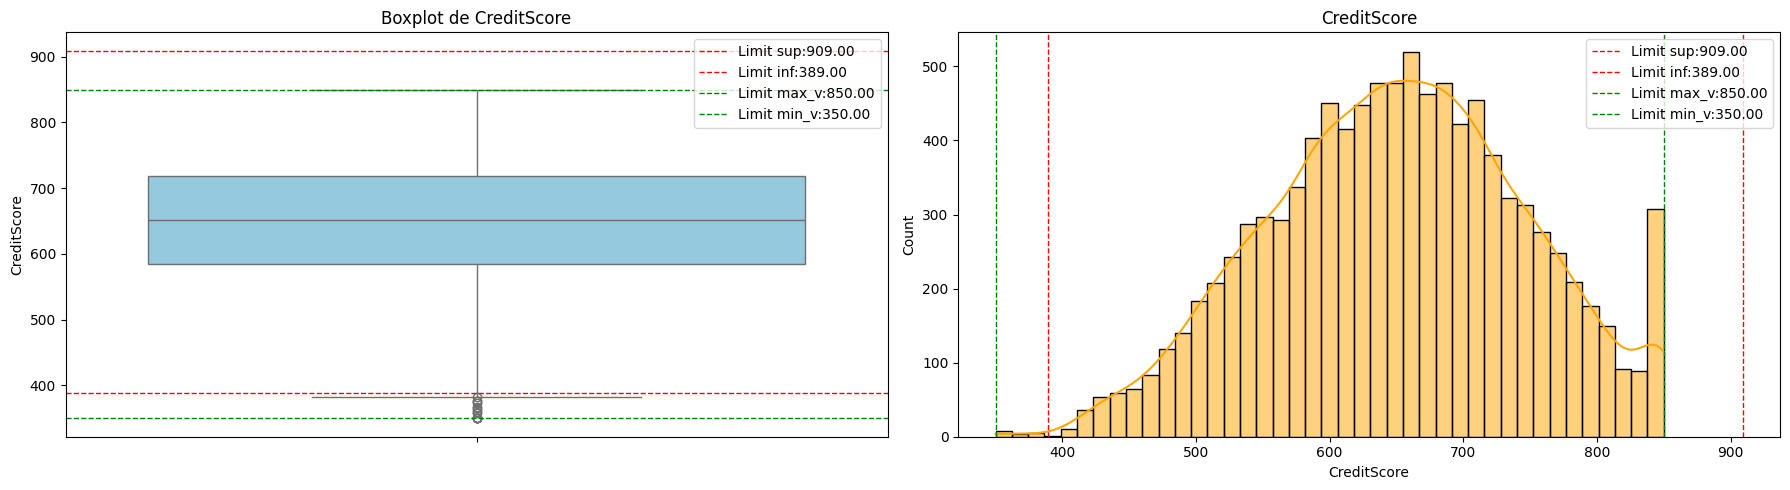

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Age
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  32.0
Q3 (75%) :  44.0
IQR :  12.0
Total outlier :  359


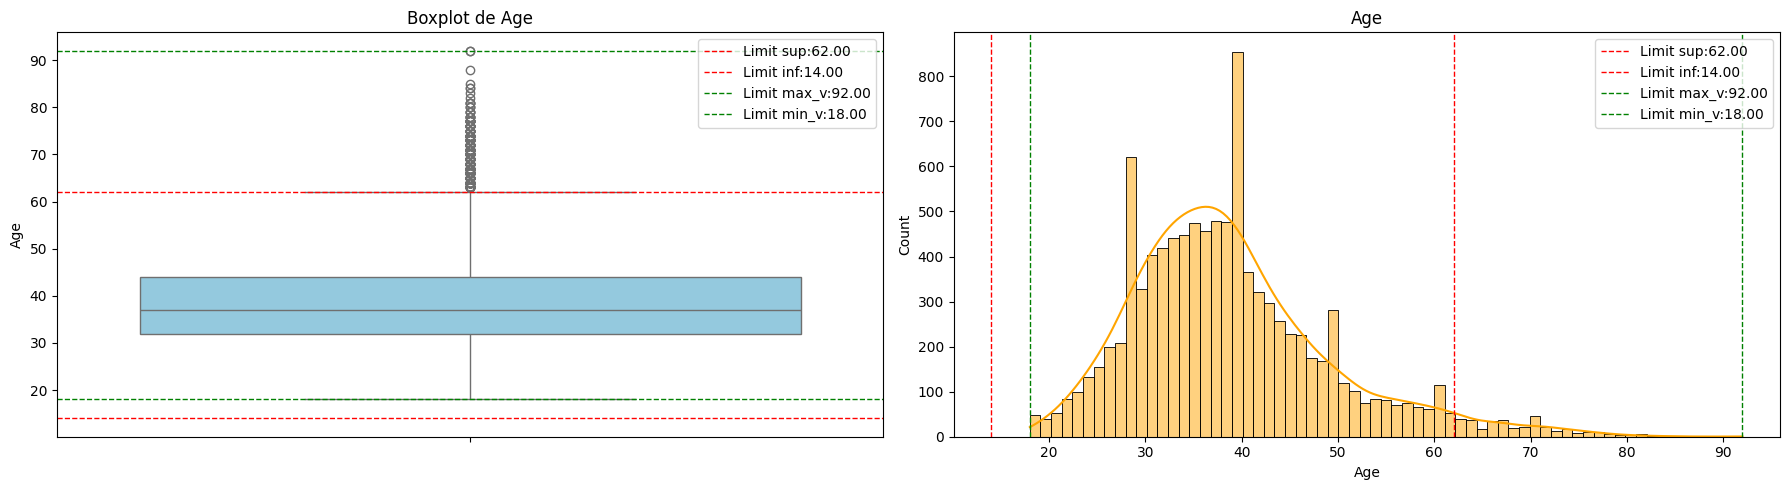

,col,Q1,Q3,IQR,lower,upper,outliers_total
0,CreditScore,584.0,714.0,130.0,389.0,909.0,17
1,Age,32.0,44.0,12.0,14.0,62.0,359


In [36]:
num_cols = ['CreditScore', 'Age']

report_df = outliers_detections_cols(df_encoded, num_cols, 0.25, 0.75)

display(report_df)


In [37]:


def preparation_finale_model(df: DataFrame, 
                             winsor_lower=0.011, 
                             winsor_upper=0.01):
    """
    Prépare les données pour le modèle :
    - Transformation logarithmique de Age
    - Winsorisation de CreditScore (limite les valeurs extrêmes)
    """

    # 1️⃣ Transformation log de Age
    # On ajoute 1 comme dans log1p pour éviter log(0)
    df = df.withColumn("Age", F.log1p(F.col("Age")))

    # 2️⃣ Winsorisation de CreditScore
    # On calcule les quantiles inférieurs et supérieurs
    q_low, q_high = df.approxQuantile("CreditScore", [winsor_lower, 1 - winsor_upper], 0.01)

    df = df.withColumn(
        "CreditScore",
        F.when(F.col("CreditScore") < q_low, q_low)
         .when(F.col("CreditScore") > q_high, q_high)
         .otherwise(F.col("CreditScore"))
    )

    return df



df_prepare = preparation_finale_model(df_encoded)

df_prepare.select("Age", "CreditScore").show(5)


+------------------+-----------+
|               Age|CreditScore|
+------------------+-----------+
|3.7612001156935624|      619.0|
|3.7376696182833684|      608.0|
|3.7612001156935624|      502.0|
|3.6888794541139363|      699.0|
| 3.784189633918261|      850.0|
+------------------+-----------+
only showing top 5 rows



=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Age
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  3.4965075614664802
Q3 (75%) :  3.8066624897703196
IQR :  0.3101549283038394
Total outlier :  182


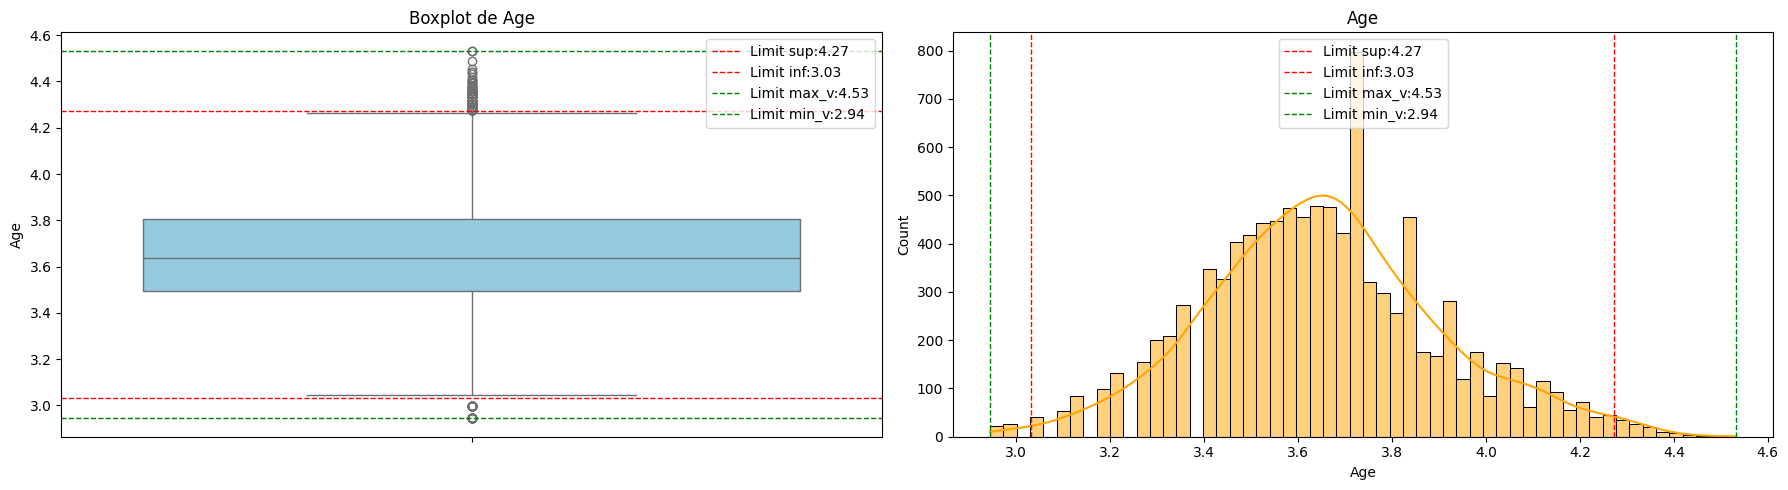

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
CreditScore
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  584.0
Q3 (75%) :  714.0
IQR :  130.0
Total outlier :  0


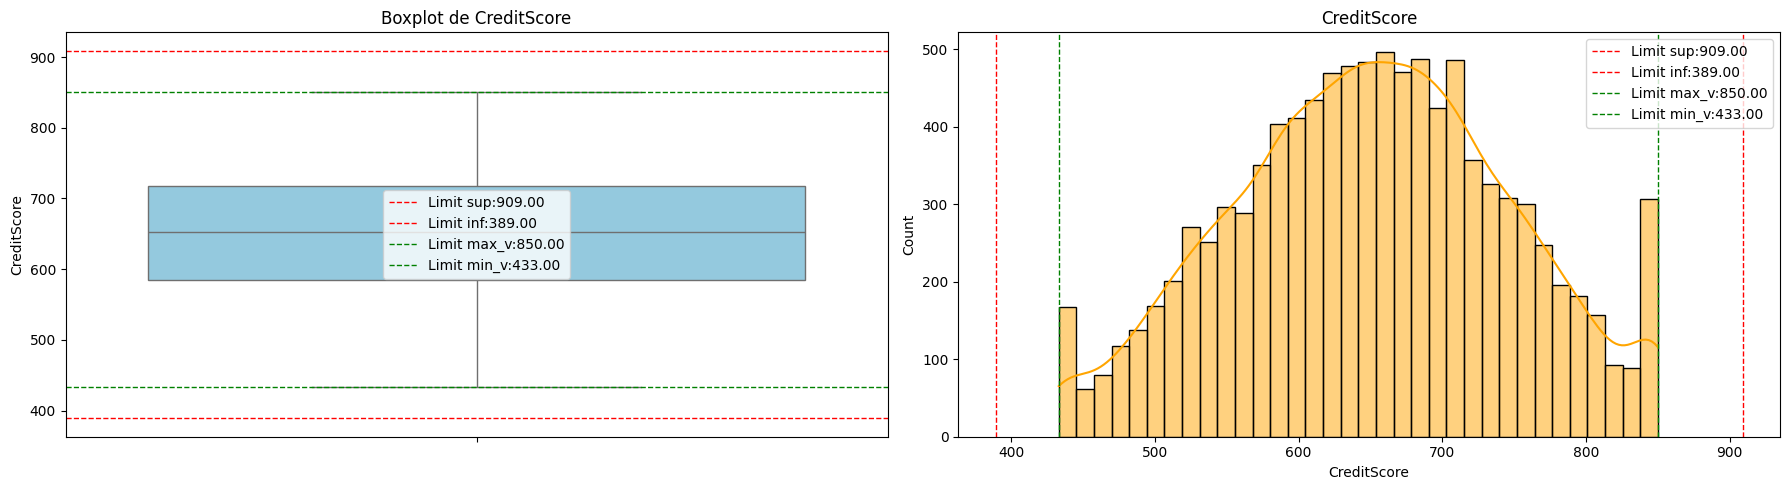

,col,Q1,Q3,IQR,lower,upper,outliers_total
0,Age,3.496508,3.806662,0.310155,3.031275,4.271895,182
1,CreditScore,584.000000,714.000000,130.000000,389.000000,909.000000,0


In [38]:
cols_verify = ['Age', 'CreditScore']


out_reports = outliers_detections_cols(df_prepare, cols_verify, )
out_reports

In [39]:

df_clipped = df_prepare.withColumn(
    "Age",
    F.when(F.col("Age") < out_reports['lower'][0], out_reports['lower'][0]) 
     .when(F.col("Age") > out_reports['upper'][0], out_reports['upper'][0])
     .otherwise(F.col("Age"))
)



=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Age
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Q1 (25%) :  3.4965075614664802
Q3 (75%) :  3.8066624897703196
IQR :  0.3101549283038394
Total outlier :  0


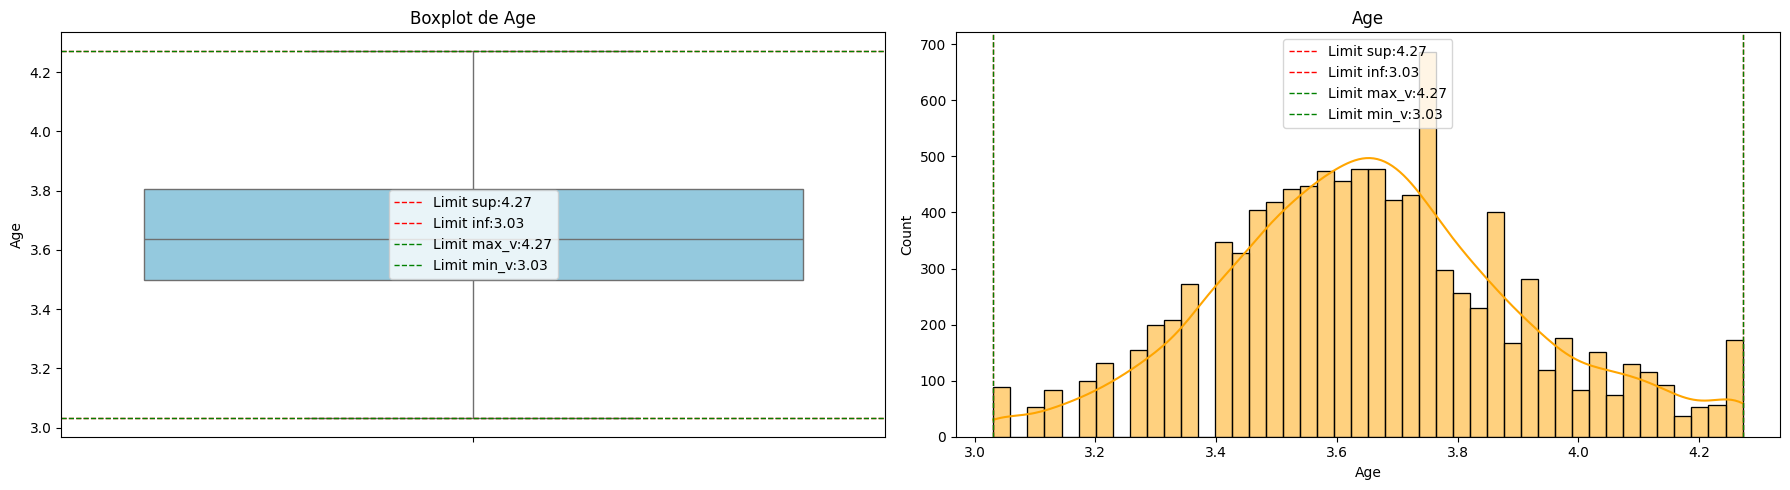

,col,Q1,Q3,IQR,lower,upper,outliers_total
0,Age,3.496508,3.806662,0.310155,3.031275,4.271895,0


In [40]:
cols_verify = ['Age']


out_reports = outliers_detections_cols(df_clipped, cols_verify)
out_reports

In [41]:
df_clipped.show(5)

+-----------+------------------+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|CreditScore|               Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Geography_Index|Gender_Index|
+-----------+------------------+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|      619.0|3.7612001156935624|     2|      0.0|            1|        1|             1|      101348.88|     1|              0|           1|
|      608.0|3.7376696182833684|     1| 83807.86|            1|        0|             1|      112542.58|     0|              2|           1|
|      502.0|3.7612001156935624|     8| 159660.8|            3|        1|             0|      113931.57|     1|              0|           1|
|      699.0|3.6888794541139363|     1|      0.0|            2|        0|             0|       93826.63|     0|              0|           1|
|      850.0|

***

## 🟢 Stockage Intermédiaire dans MongoDB

### 1️⃣ Conversion temporaire en DataFrame Pandas

In [42]:
df_pd = df_clipped.toPandas()
print("✅ Conversion Spark → Pandas réussie")
print(f"Nombre d’enregistrements : {len(df_pd)}")
df_pd.head(3)

✅ Conversion Spark → Pandas réussie
Nombre d’enregistrements : 10000


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Index,Gender_Index
0,619.0,3.76120,2,0.00,1,1,1,101348.88,1,0,1
1,608.0,3.73767,1,83807.86,1,0,1,112542.58,0,2,1
2,502.0,3.76120,8,159660.80,3,1,0,113931.57,1,0,1


In [43]:
data_dict = df_pd.to_dict("records")
print("✅ Transformation en liste de dictionnaires")
print(data_dict[:2])


✅ Transformation en liste de dictionnaires
[{'CreditScore': 619.0, 'Age': 3.7612001156935624, 'Tenure': 2, 'Balance': 0.0, 'NumOfProducts': 1, 'HasCrCard': 1, 'IsActiveMember': 1, 'EstimatedSalary': 101348.88, 'Exited': 1, 'Geography_Index': 0, 'Gender_Index': 1}, {'CreditScore': 608.0, 'Age': 3.7376696182833684, 'Tenure': 1, 'Balance': 83807.86, 'NumOfProducts': 1, 'HasCrCard': 0, 'IsActiveMember': 1, 'EstimatedSalary': 112542.58, 'Exited': 0, 'Geography_Index': 2, 'Gender_Index': 1}]


#### 2️⃣ Insertion dans la collection MongoDB

In [44]:

client = MongoClient("mongodb://localhost:27017/")

db = client["Attrition_Client_Bancaire_db"]
collection = db["clients_pretraite"]


In [45]:
# Suppression des anciens documents s'ils existent
collection.delete_many({})

# Insertion de toutes les données
collection.insert_many(data_dict)

print("✅ Données insérées avec succès dans MongoDB")


✅ Données insérées avec succès dans MongoDB


* Vérification de l’intégrité des données

In [46]:
print("Nombre de documents stockés :", collection.count_documents({}))
for doc in collection.find().limit(3):
    print(doc)


Nombre de documents stockés : 10000
{'_id': ObjectId('690cfee3dd8b13fbc893bfd9'), 'CreditScore': 619.0, 'Age': 3.7612001156935624, 'Tenure': 2, 'Balance': 0.0, 'NumOfProducts': 1, 'HasCrCard': 1, 'IsActiveMember': 1, 'EstimatedSalary': 101348.88, 'Exited': 1, 'Geography_Index': 0, 'Gender_Index': 1}
{'_id': ObjectId('690cfee3dd8b13fbc893bfda'), 'CreditScore': 608.0, 'Age': 3.7376696182833684, 'Tenure': 1, 'Balance': 83807.86, 'NumOfProducts': 1, 'HasCrCard': 0, 'IsActiveMember': 1, 'EstimatedSalary': 112542.58, 'Exited': 0, 'Geography_Index': 2, 'Gender_Index': 1}
{'_id': ObjectId('690cfee3dd8b13fbc893bfdb'), 'CreditScore': 502.0, 'Age': 3.7612001156935624, 'Tenure': 8, 'Balance': 159660.8, 'NumOfProducts': 3, 'HasCrCard': 1, 'IsActiveMember': 0, 'EstimatedSalary': 113931.57, 'Exited': 1, 'Geography_Index': 0, 'Gender_Index': 1}


***
***

In [47]:
data = list(collection.find({}))

for d in data:
    d.pop('_id', None)

df_pretraite = pd.DataFrame(data)

print("✅ Données prétraitées récupérées avec succès")
display(df_pretraite.head())

✅ Données prétraitées récupérées avec succès


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Index,Gender_Index
0,619.0,3.761200,2,0.00,1,1,1,101348.88,1,0,1
1,608.0,3.737670,1,83807.86,1,0,1,112542.58,0,2,1
2,502.0,3.761200,8,159660.80,3,1,0,113931.57,1,0,1
3,699.0,3.688879,1,0.00,2,0,0,93826.63,0,0,1
4,850.0,3.784190,2,125510.82,1,1,1,79084.10,0,2,1


In [48]:

df_spark = spark.createDataFrame(df_pretraite)

In [49]:
df_spark

DataFrame[CreditScore: double, Age: double, Tenure: bigint, Balance: double, NumOfProducts: bigint, HasCrCard: bigint, IsActiveMember: bigint, EstimatedSalary: double, Exited: bigint, Geography_Index: bigint, Gender_Index: bigint]

In [50]:
df_clients.show(3)

+---------+----------+--------+-----------+---------+------+---+------+--------+-------------+---------+--------------+---------------+------+----------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure| Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|TrancheAge|
+---------+----------+--------+-----------+---------+------+---+------+--------+-------------+---------+--------------+---------------+------+----------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|     0.0|            1|        1|             1|      101348.88|     1|   Matures|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1|83807.86|            1|        0|             1|      112542.58|     0|   Matures|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8|159660.8|            3|        1|             0|      113931.57|     1|   Matures|
+---------+----------+--------+-----------+---------+------+---+------+-----

In [51]:
df_spark.show(5)

Py4JJavaError: An error occurred while calling o1016.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 242.0 failed 1 times, most recent failure: Lost task 0.0 in stage 242.0 (TID 178) (Bouchra executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:621)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:624)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2898)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2834)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2833)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2833)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1253)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3102)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3036)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3025)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:995)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at jdk.internal.reflect.GeneratedMethodAccessor82.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:621)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:624)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more


***
***

* stoper spark : 

In [ ]:
# spark.stop()